In [558]:
import gseapy
import shutil
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm # recommended import according to the docs
from beeswarm import *
import seaborn.apionly as sns
from ggplot import *
from scipy.stats import ttest_ind, ttest_ind_from_stats
import scipy.optimize as so
import statsmodels.api as sm
from scipy.stats import gaussian_kde
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_style("ticks")
font = {'family' : 'helvetica',
        'size'   : 14}

matplotlib.rc('font', **font)

In [11]:
def S2N(CCLE,sensitive,resistant):
    data_s = CCLE[CCLE["Cell.Line"].isin(sensitive)]
    data_r = CCLE[CCLE["Cell.Line"].isin(resistant)]
    sens_genes_mean = []; sens_genes_sd = []
    resi_genes_mean = []; resi_genes_sd = []
    genes_p = []
    for i in range(1 , data_s.shape[1]):
        sens_genes_mean.append(np.mean(data_s[data_s.columns[i]]))
        sens_genes_sd.append(np.std(data_s[data_s.columns[i]], axis = 0, ddof = 1))
        resi_genes_mean.append(np.mean(data_r[data_r.columns[i]]))
        resi_genes_sd.append(np.std(data_r[data_r.columns[i]], axis = 0, ddof = 1))
        genes_p.append(sm.stats.ttest_ind(data_s[data_s.columns[i]],data_r[data_r.columns[i]],alternative="two-sided")[1])
    sens_genes_mean = np.array(sens_genes_mean);sens_genes_sd = np.array(sens_genes_sd)
    resi_genes_mean = np.array(resi_genes_mean);resi_genes_sd = np.array(resi_genes_sd)
    S2N = (sens_genes_mean - resi_genes_mean) / (sens_genes_sd + resi_genes_sd)
    S2N_df = pd.DataFrame({"S2N":S2N, "pvalue":genes_p,
                           "genes":CCLE.columns.tolist()[1:],
                           "sens_mean":sens_genes_mean,
                           "sens_sd":sens_genes_sd,
                           "resi_mean":resi_genes_mean,
                           "resi_sd":resi_genes_sd})
    return S2N_df

In [12]:
def dropUnnamedColumns(DataFrame):
    cols = DataFrame.columns
    indexes = []
    cnt=0
    for i in cols:
        if "Unnamed" in i:
            indexes.append(cnt)
        cnt+=1
    return DataFrame.drop(cols[indexes],axis=1)

In [13]:
test = pd.read_csv("/Users/brentkuenzi/Documents/Drug SVM/R_analysis/CCLE.txt",sep="\t")
test = dropUnnamedColumns(test)
test = test.drop_duplicates(subset=["Cell.Line"])
test_S2N = S2N(test,["NCIH1155_LUNG","NCIH460_LUNG","NCIH1299_LUNG"],["NCIH650_LUNG","NCIH23_LUNG","NCIH661_LUNG","HCC2935_LUNG"])

/Users/brentkuenzi/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


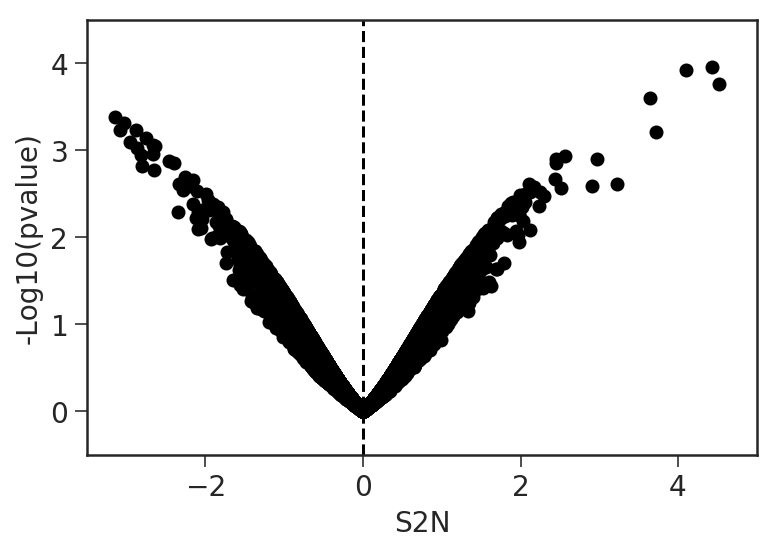

In [14]:
test_S2N["-log10(pvalue)"] = -np.log10(test_S2N["pvalue"])
plt.scatter(data=test_S2N,x="S2N",y="-log10(pvalue)",color="black")
plt.xlim(-3.5,5); plt.ylim(-0.5,4.5)
plt.ylabel("-Log10(pvalue)"); plt.xlabel("S2N")
plt.axvline(0,color="black",ls="dashed")

In [588]:
def find_confidence_interval(x, pdf, confidence_level):
    return pdf[pdf > x].sum() - confidence_level
def density_contour(xdata, ydata, nbins_x, nbins_y, ax=None, **contour_kwargs):
    """ Create a density contour plot.
    Parameters
    ----------
    xdata : numpy.ndarray
    ydata : numpy.ndarray
    nbins_x : int
        Number of bins along x dimension
    nbins_y : int
        Number of bins along y dimension
    ax : matplotlib.Axes (optional)
        If supplied, plot the contour to this axis. Otherwise, open a new figure
    contour_kwargs : dict
        kwargs to be passed to pyplot.contour()
    """

    H, xedges, yedges = np.histogram2d(xdata, ydata, bins=(nbins_x,nbins_y), normed=True)
    x_bin_sizes = (xedges[1:] - xedges[:-1]).reshape((1,nbins_x))
    y_bin_sizes = (yedges[1:] - yedges[:-1]).reshape((nbins_y,1))

    pdf = (H*(x_bin_sizes*y_bin_sizes))

    one_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.68))
    two_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.95))
    three_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.99))
    levels = [one_sigma, two_sigma, three_sigma]

    X, Y = 0.5*(xedges[1:]+xedges[:-1]), 0.5*(yedges[1:]+yedges[:-1])
    Z = pdf.T

    if ax == None:
        plt.contour(X, Y, Z, levels=levels.sort(), origin="lower", **contour_kwargs)
    else:
        ax.contour(X, Y, Z, levels=levels.sort(), origin="lower", **contour_kwargs)
def scatterhist(x,y,data=None, binwidth=0.25, xlim=None, ylim=None,pointEdgecolors='black',alpha=1,
                pointColor="blue",topHistColor = "gray",rightHistColor = "gray",histEdgeColor="black",
               xlab = "X",ylab="Y",corrLine=True,corrLineColor="black",corrLineWidth=2,corrLineType = "-", histbox = False,
               contour=False,nbins_x=20,nbins_y=20,contourColor="white",hist_alpha=1,
               contour_alpha=1):
    """
    This function takes either two lists or a pandas dataframe and the column
    names of the comparison to be done and plots the ScatterHist. A trend line 
    is added by default using least squares regression.
    """
    from matplotlib.ticker import NullFormatter
    
    if data != None:
        x = data[x]
        y = data[y]

    rect_scatter = [0.1, 0.1, 0.65, 0.65]
    rect_histx = [0.1, 0.77, 0.65, 0.2]
    rect_histy = [0.77, 0.1, 0.2, 0.65]

    plt.figure(1, figsize=(8, 8))
    axScatter = plt.axes(rect_scatter)
    axHistx = plt.axes(rect_histx)
    axHisty = plt.axes(rect_histy)
    axHistx.xaxis.set_major_formatter(NullFormatter())
    axHisty.yaxis.set_major_formatter(NullFormatter())

    axScatter.scatter(x, y,color=pointColor,edgecolors=pointEdgecolors,alpha=alpha)
    if corrLine:
        from scipy.stats import linregress
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        print "R = "+str(r_value), ", pvalue = "+str(p_value), ", std err = "+str(std_err)
        axScatter.plot(x, intercept + slope*x,color=corrLineColor,linewidth=corrLineWidth,linestyle=corrLineType)
    xymax = np.max([np.max(np.fabs(x)), np.max(np.fabs(y))])
    lim = (int(xymax/binwidth) + 1) * binwidth
    if xlim!= None:
        xlim = (-lim,lim)
    if ylim!= None:
        ylim = (-lim,lim)
    axScatter.set_xlim(xlim)
    axScatter.set_ylim(ylim)
    axScatter.set_xlabel(xlab,size=18)
    axScatter.set_ylabel(ylab,size=18)
    if contour:
        density_contour(x,y,nbins_x,nbins_y,ax=axScatter,colors=contourColor,alpha = contour_alpha)
    bins = np.arange(-lim, lim + binwidth, binwidth)
    axHistx.hist(x, bins=bins,color=topHistColor,edgecolor=histEdgeColor,alpha=hist_alpha)
    axHisty.hist(y, bins=bins, orientation='horizontal',color=rightHistColor,edgecolor=histEdgeColor,alpha=hist_alpha)
    if histbox == False:
        axHistx.axis("off"); axHisty.axis("off")

    axHistx.set_xlim(axScatter.get_xlim())
    axHisty.set_ylim(axScatter.get_ylim())
    plt.show()

R = 0.903590549315 , pvalue = 0.0 , std err = 0.00422518600286


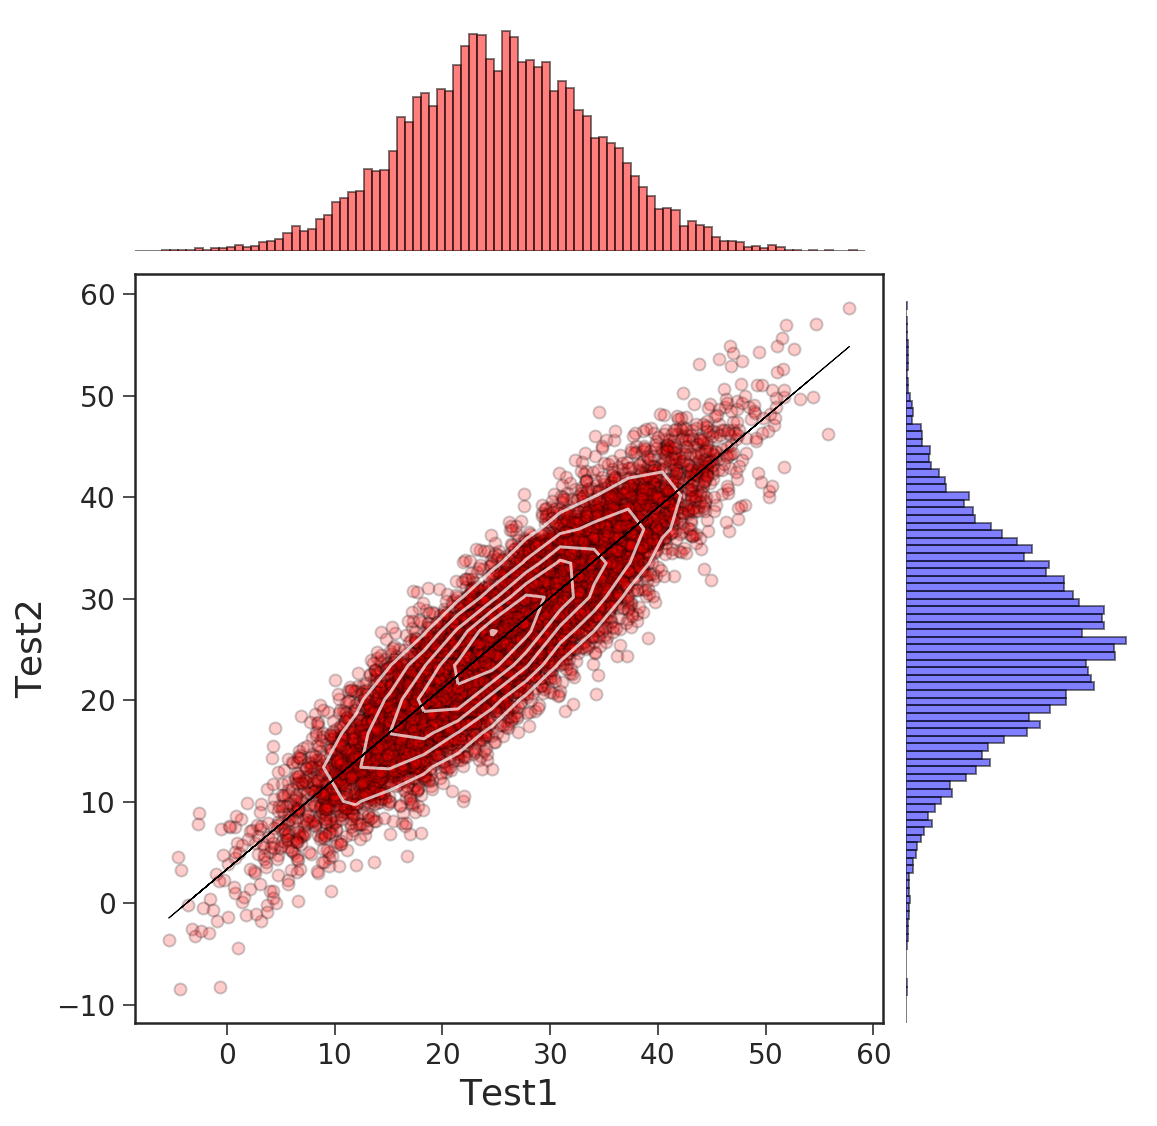

In [614]:
# Create correlated random dataset
xx = np.array([-0.51, 51.2]); yy = np.array([0.33, 51.6])
means = [xx.mean(), yy.mean()]; stds = [xx.std() / 3, yy.std() / 3]
corr = 0.9; covs = [[stds[0]**2, stds[0]*stds[1]*corr], 
        [stds[0]*stds[1]*corr, stds[1]**2]] 
m = np.random.multivariate_normal(means, covs, 10000).T
# Test scatterhist
scatterhist(x=m[0],y=m[1],pointColor="red",xlab="Test1",alpha=0.2,binwidth=0.75,
            ylab="Test2",histbox=False,contour=True,contourColor="white",
           hist_alpha=0.5,topHistColor="red",rightHistColor="blue",
           contour_alpha=0.7,corrLineColor="black",corrLineWidth=0.5)

In [673]:
def KStestRanked(gene_subset,full_set,sort_column,identifier,permutations=5000,direction="up"):
    """
    This function performs a modified Kolmogorov Smirnov test (ranked). gene_subset is
    a list of genes to be tested. full_set is a Pandas dataframe. column is the
    column of the dataset to rank on. Permutations is number of permutations of
    random sampling for p-value estimation. direction is for determination of
    degree of up or downregulation.

    This modification is distinct from a standard KS test in several ways: First, when
    comparing a large distribution to a small distribution in a standard KS test, the NULL
    hypothesis is biased towards being rejected, and thus introduce false positives. Second,
    a ranked KS test allows for the preferential ranking of sets that are separated from the
    background at the tails of the distribution.
    """
    # sort gene_subset and full_set!!!! Sort on "sort_column", identifier is gene names or similar
    full_set = full_set.sort_values(sort_column,ascending=False)
    t = len(gene_subset); n = len(full_set); u_list = []; cnt = 1
    j = lambda x: list(full_set[full_set[identifier].isin(gene_subset)][identifier]).index(x)+1
    v_j = lambda x: list(full_set[identifier]).index(x)+1
    if direction == "up":
        for i in gene_subset:
            u_list.append((j(i)/t)-(v_j(i)/n))
        u = max(u_list)
    elif direction == "down":
        for i in gene_subset:
            u_list.append((v_j(i)/n)-((j(i)-1)/t))
        u = max(u_list)
    else:
        sys.exit("Please select 'up' or 'down'")
    perm = 0
    u_instances = 0
    while perm < permutations:
        random = full_set.sample(frac=(t/float(n))) # do I need to sort this?
        j = lambda x: list(random[random[identifier].isin(gene_subset)][identifier]).index(x)+1
        v_j = lambda x: list(random[identifier]).index(x)+1
        u_list = []
        for i in random[identifier]:
            if direction == "up":
                u_list.append((j(i)/t)-(v_j(i)/n)) # need to fix for random sampling - new lambdas for j and v_j
            else:
                u_list.append((v_j(i)/n)-((j(i)-1)/t)) # need to fix for random sampling - new lambdas for j and v_j
        u_random = np.max(u_list)
        if u_random > u:
            u_instances += 1
        perm += 1
    pvalue = u_instances / permutations
    return pvalue

In [674]:
test = pd.DataFrame({"Genes" :["A","B","C","D","E",
                               "F","G","H","I","J",
                               "K","L","M","N","O",
                               "P","Q","R","S","T"],
                    "Values":[1,1,1,1,1,
                              5,5,5,5,5,
                             1,1,1,1,1,
                             1,1,1,1,1]})
#list(test[test["Genes"].isin(["E","F","G","H"])]["Genes"]).index("E")
KStestRanked(["E","F","G"],test,"Values","Genes",10000)

ValueError: 'T' is not in list

In [127]:
def KEGGanalysis(genes,cutoff=0.1,gene_sets="KEGG_2016",description="pathway"):
    """
    This function performs KEGG analysis on a gene set. Input is a list gene names.
    """
    gseapy.enrichr(gene_list=genes, description=description, gene_sets=gene_sets, outdir='test',cutoff=cutoff)
    output = pd.read_csv("test/"+gene_sets+".pathway.enrichr.reports.txt",sep="\t")
    shutil.rmtree("test")
    return output
def PlotKEGG(KEGGobject,color="black",x="P-value",abline = 0.05,abline_color="red"):
    """
    This function visualizes the output from KEGGanalysis. Input is pandas DF from KEGGanalysis
    """
    KEGGobject["-log10(pvalue)"] = -np.log10(KEGGobject[x])
    plot = KEGGobject.sort_values(x)
    objects = plot["Term"]
    objects2 = []
    for i in objects:
        objects2.append(i.split("_")[0])
    y_pos = list(range(len(plot["-log10(pvalue)"])))
    performance = plot["-log10(pvalue)"]
    fig, ax = plt.subplots()
    ax.barh(y_pos, performance, align='center', alpha=0.5,color=color,edgecolor="black")
    ax.invert_yaxis()
    ax.set_yticks(y_pos)
    ax.set_yticklabels(objects2)
    ax.set_xlabel('-Log10(P-value)')
    plt.axvline(x=abline,color=abline_color)
    plt.show()

#### Example

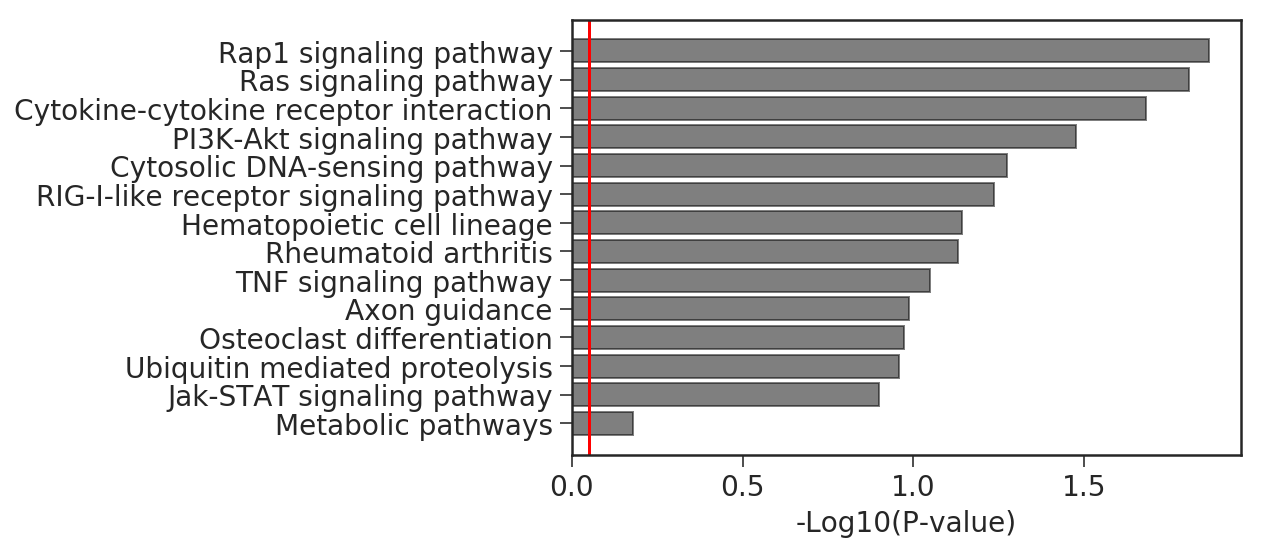

In [131]:
gl = ['SCARA3', 'LOC100044683', 'CMBL', 'CLIC6', 'IL13RA1', 'TACSTD2', 'DKKL1', 'CSF1',
     'SYNPO2L', 'TINAGL1', 'PTX3', 'BGN', 'HERC1', 'EFNA1', 'CIB2', 'PMP22', 'TMEM173']
pathways = KEGGanalysis(gl,gene_sets="KEGG_2016")
PlotKEGG(pathways)

# Cumulative Distribution Function

In [149]:
def plotECDF(sample1,sample2,xlab="x",ylab="ECDF",
             title="Empirical Distribution Function",
             color1="red",color2="black",nullLine=False):
    ecdf = sm.distributions.ECDF(sample)
    ecdf2 = sm.distributions.ECDF(sample2)
    x1 = np.linspace(min(sample), max(sample))
    y = ecdf(x1)
    x2 = np.linspace(min(sample2), max(sample))
    y2 = ecdf(x2)
    if nullLine:
        plt.plot([0,1],[0,1],linestyle="--",color="black",linewidth=1)
    plt.step(x1, y,color=color1)
    plt.step(x2,y2,color=color2)
    plt.ylabel(ylab); plt.xlabel(xlab)
    plt.suptitle(title)
    plt.show()

**Example**

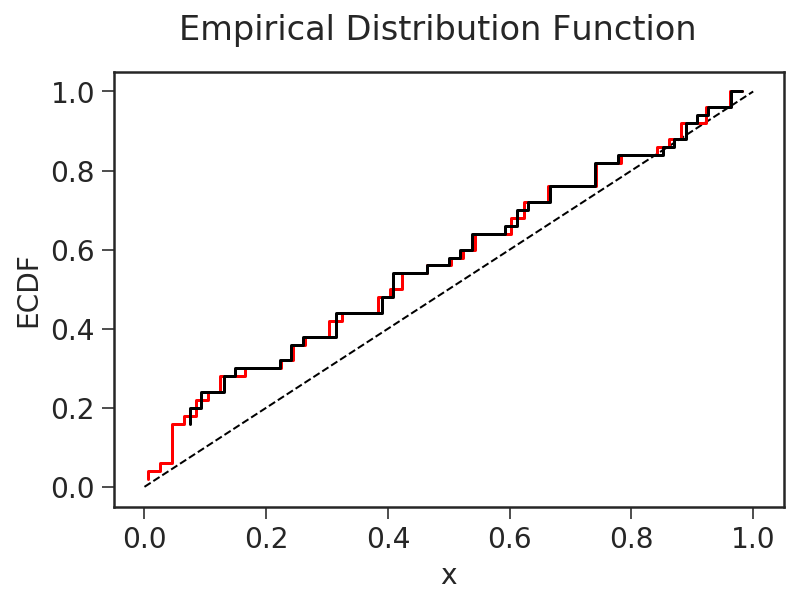

In [150]:
sample = np.random.uniform(0, 1, 50)
sample2 = np.random.uniform(0, 50, 900)
plotECDF(sample,sample2,nullLine=True)

# Boxplot

In [467]:
def plot_boxplot(dataframe,edge_color = "black", fill_color="white",
              xlabel="Group",ylabel="Value",notch=True):
    data = dataframe.as_matrix()
    labs = list(dataframe.columns.values)
    bp = plt.boxplot(data, patch_artist=True,notch=notch)
    ind = range(dataframe.shape[1])
    ind2 = [x+1 for x in ind]
    plt.xticks(ind2, labs)
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)
    cnt=0
    for patch in bp['boxes']:
        if isinstance(fill_color, list):
            patch.set(facecolor=fill_color[cnt])
            cnt+=1
        else:
            patch.set(facecolor=fill_color)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

#### Example

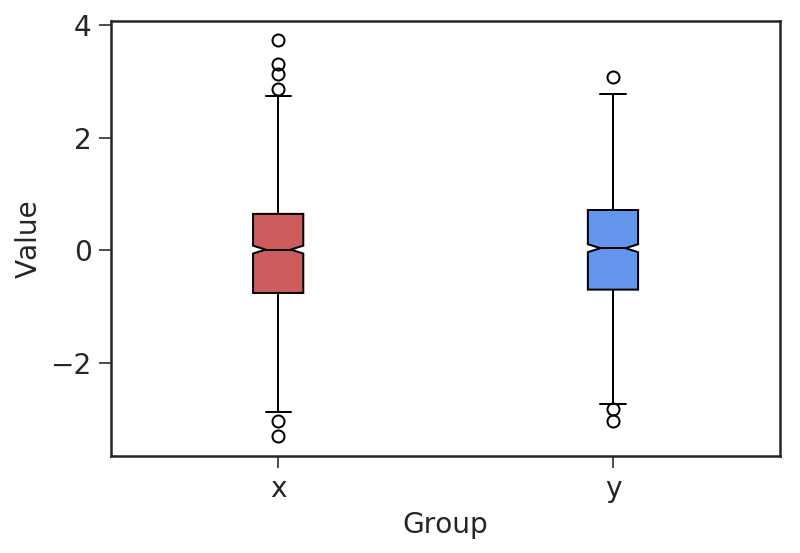

In [468]:
x = np.random.randn(1000); y = np.random.randn(1000)
test = pd.DataFrame({"x":list(x),"y":list(y)})
plot_boxplot(test,fill_color=["indianred","cornflowerblue"])

# Dose Response & IC50 Determination

In [800]:
from scipy.optimize import curve_fit
from scipy.optimize import minimize_scalar
def sigmoid(x, x0, k):
     return 1 / (1 + np.exp(-k*(x-x0)))
def objective(x, b, c):
    return (0.5 - sigmoid(x, b, c)) ** 2
def plotDRC(xdata,ydata,pointColor="green",fitColor="purple",IC50lines=True,
               xlabel="Dose",ylabel="Response",title="Drug Name",shade=False,
           shadeColor = "lightgray"):
    popt, pcov = curve_fit(sigmoid, xdata, ydata)
    res = minimize_scalar(objective, args=tuple(popt))
    x = np.linspace(np.min(xdata), np.max(xdata))
    y = sigmoid(x, *popt)
    fig, ax = plt.subplots(1,1)
    ax.plot(xdata, ydata, 'o', label='data',color=pointColor)
    ax.plot(x,y, label='fit',color=fitColor)
    ax.set_ylim(0, 1.05)
    ax.set_title(title)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    if IC50lines:
        ax.plot([0-np.median(xdata)/10,res.x],[0.5,0.5],linestyle="--",color="black",linewidth=1)
        ax.plot([res.x,res.x],[0,0.5],linestyle="--",color="black",linewidth=1)
        ax.set_xlim(0-np.median(xdata)/10)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.text(0.1,0.05,"IC50 = "+str(round(res.x,2)))
    if shade:
        ax.fill_between(x, y, np.zeros(len(y)), where = y >= np.zeros(len(y)), facecolor=shadeColor, interpolate=True)

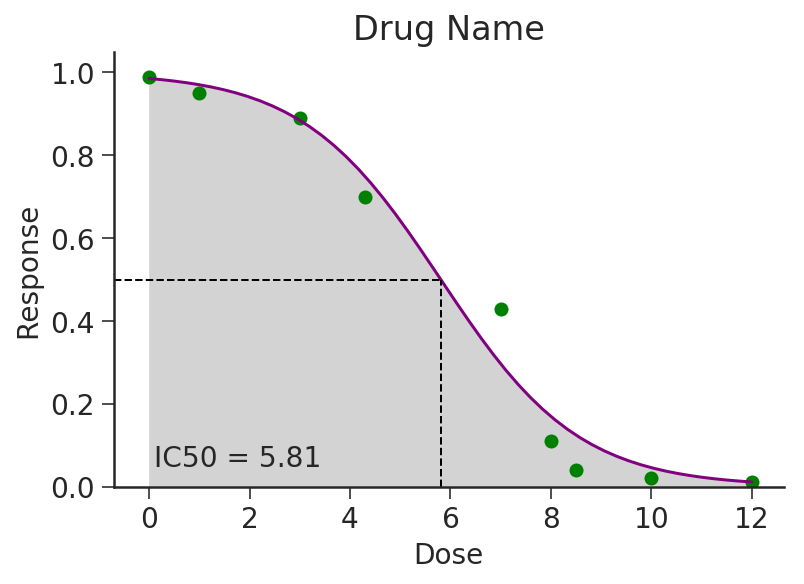

In [801]:
xdata = np.array([0.0,   1.0,  3.0, 4.3, 7.0,   8.0,   8.5, 10.0, 12.0])
ydata = np.array([0.01, 0.02, 0.04, 0.11, 0.43,  0.7, 0.89, 0.95, 0.99])[::-1]
plotDRC(xdata,ydata,shade=True)

# Connection Graphs

In [117]:
def ColumnConnect(left,right,connections,ascending=True,color="gray",xlab=False):
    """
    This plot takes a list of genes for both left and right columns and draws
    user specified connections between them. This is similar a network diagram but
    could also be used to display significant associations or kinase-substrate
    relationships.
    Left and right are lists of genes in order that they are to be plotted.
    Connections is a dictionary of edges to add.
    """
    left_x = np.repeat(0,len(left))
    right_x = np.repeat(5,len(right))
    left_y = range(len(left))
    right_y = range(len(right))
    if not ascending:
        left_y = left_y[::-1]
        right_y = right_y[::-1]
    plt.xlim(np.min(left_x)-1,np.max(right_x)+1);plt.ylim(np.min(left_y)-1,np.max(left_y)+1)
    plt.axis("off")
    for i in range(len(left)):
        plt.text(x=left_x[i],y=left_y[i],s=left[i],horizontalalignment="right")
        plt.text(x=right_x[i],y=right_y[i],s=right[i],horizontalalignment = "left")
    for i in connections.keys():
        for j in connections[i]:
            plt.plot([left_x[left.index(i)]+0.25, right_x[right.index(j)]-0.25],
                    [left_y[left.index(i)], right_y[right.index(j)]],"-",color=color)
    if xlab:
        plt.text(x=0,y=-1,s="Source",horizontalalignment="right",fontweight='bold')
        plt.text(x=5,y=-1,s="Target",horizontalalignment="left",fontweight='bold')
    plt.show()


**Example**

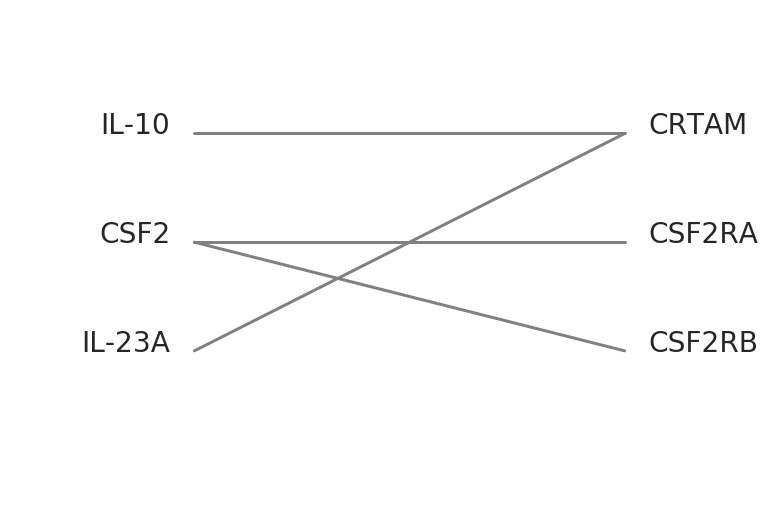

In [118]:
left = ["IL-10","CSF2","IL-23A"]; right = ["CRTAM","CSF2RA","CSF2RB"]
connections = {"IL-10":["CRTAM"],"CSF2":["CSF2RB","CSF2RA"],"IL-23A":["CRTAM"]}

ColumnConnect(left,right,connections,False)

#### You can use this also in multipanel plots such as to look at network degree

In [125]:
def DegreeConnect(left,right,connections,barcolor="gray",xlabel="Degree",ascending=True,linecolor="gray"):
    """
    This plot takes a list of genes for both left and right columns and draws
    user specified connections between them. This is similar a network diagram but
    could also be used to display significant associations or kinase-substrate
    relationships.
    Left and right are lists of genes in order that they are to be plotted.
    Connections is a dictionary of edges to add.
    
    This also plots the degree for each of the nodes
    """
    counts1 = []
    for i in left:
        counts1.append(len(connections[i]))
    counts = [i * -1 for i in counts1]
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    left_y = range(len(left))
    if not ascending:
        counts = counts[::-1]
    ax1.barh(left_y,counts,
             color=barcolor,edgecolor="black",align="center")
    locs = ax1.xaxis.get_majorticklocs()
    labels = [int(i * -1) for i in locs]
    ax1.set_xticklabels(labels)
    ax1.get_yaxis().set_visible(False)
    ax1.set_xlabel(xlabel)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(True)
    ax1.spines['bottom'].set_visible(True)
    ax1.spines['left'].set_visible(False)
    ColumnConnect(left,right,connections,ascending,color=linecolor)

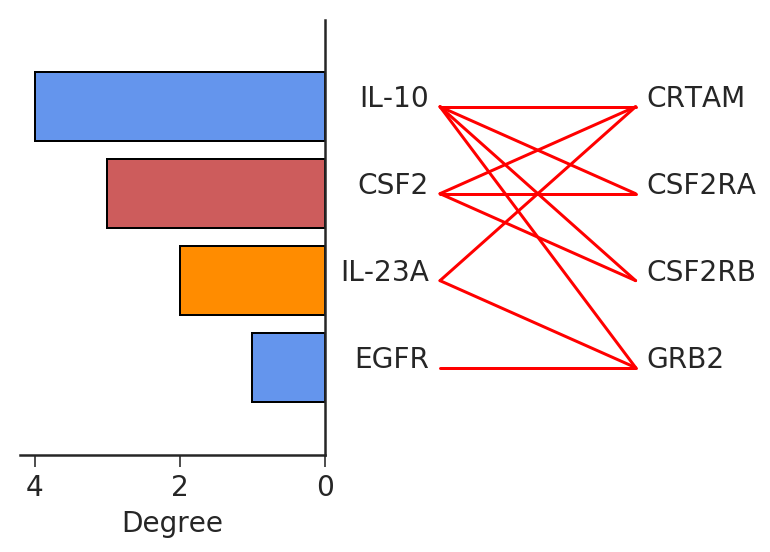

In [126]:
left = ["IL-10","CSF2","IL-23A","EGFR"]; right = ["CRTAM","CSF2RA","CSF2RB","GRB2"]
connections = {"IL-10":["CRTAM","CSF2RA","GRB2","CSF2RB"],
               "CSF2":["CSF2RB","CSF2RA","CRTAM"],
               "IL-23A":["CRTAM","GRB2"],
              "EGFR":["GRB2"]}
DegreeConnect(left,right,connections,
              barcolor=["cornflowerblue","darkorange","indianred"],
             ascending=False,linecolor="red")


**Or with useful node information**

In [95]:
def FoldChangeConnect(left,right,connections,foldchange,
                      linecolor="gray",ascending=True,barcolor="gray",
                     xlabel="Fold Change"):
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    left_y = range(len(left))
    if not ascending:
        ax1.barh(left_y,foldchange[::-1],color=barcolor,edgecolor="black",align="center")
    else:
        ax1.barh(left_y,foldchange,color=barcolor,edgecolor="black",align="center")
    ax1.axvline(0,color="black",linestyle="-",linewidth=1)
    ax1.get_yaxis().set_visible(False)
    ax1.set_xlabel(xlabel)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(True)
    ax1.spines['left'].set_visible(False)
    ColumnConnect(left,right,connections,ascending,linecolor)

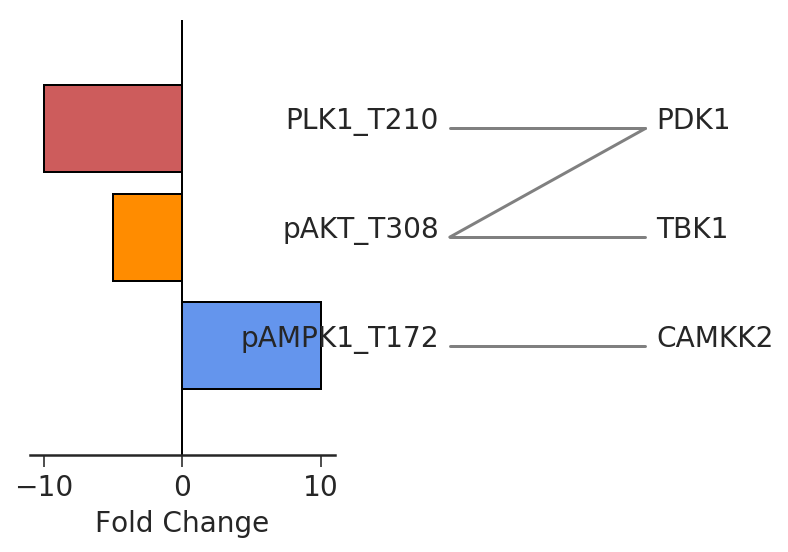

In [351]:
left = ["pAMPK1_T172","pAKT_T308","PLK1_T210"]; right = ["CAMKK2","TBK1","PDK1"]
connections = {"pAMPK1_T172":["CAMKK2"],"pAKT_T308":["PDK1","TBK1"],"PLK1_T210":["PDK1"]}
FoldChangeConnect(left,right,connections,[10,-5,-10],
                  barcolor=["cornflowerblue","darkorange","indianred"],
                 ascending=True)


# Lasso Regression
This section was created as part of the University of Washington - Machine Learning Specialization from Coursera. Use of lasso regression in SciKit-Learn is recommended over these functions for machine learning.

In [385]:
import graphlab as gl
def SFrame_to_numpy(data_sframe, features, output):
    data_sframe['constant'] = 1 
    features = ['constant'] + features 
    features_sframe = data_sframe[features]
    feature_matrix = features_sframe.to_numpy()
    output_sarray = data_sframe[output]
    output_array = output_sarray.to_numpy()
    return(feature_matrix, output_array)
def predict_output(feature_matrix, weights):
    predictions = np.dot(feature_matrix, weights)
    return(predictions)
def normalize_features(feature_matrix):
    norms = np.linalg.norm(feature_matrix, axis=0)
    normalized_features = feature_matrix / norms
    return (normalized_features, norms)
def lasso_coordinate_descent_step(i, feature_matrix, output, weights, l1_penalty):
    prediction = predict_output(feature_matrix, weights)
    feature = feature_matrix[:, i]
    ro_i = (feature * (output - prediction + weights[i] * feature)).sum()
    if i == 0: # intercept -- do not regularize
        new_weight_i = ro_i 
    elif ro_i < -l1_penalty/2.:
        new_weight_i = (ro_i + l1_penalty/2.)
    elif ro_i > l1_penalty/2.:
        new_weight_i = (ro_i - l1_penalty/2.)
    else:
        new_weight_i = 0.
    return new_weight_i
def lasso_cyclical_coordinate_descent(feature_matrix, output, initial_weights, l1_penalty, tolerance):
    """
    For each iteration:
    1) As you loop over features in order and perform coordinate descent, measure how much each coordinate changes.
    2) After the loop, if the maximum change across all coordinates is falls below the tolerance, stop. Otherwise, go back to step 1.
    3) Return weights
    """
    converged = False
    weights = np.array(initial_weights.copy())
    while not converged:
        change = list()
        for i in range(len(weights)):
            old_weights_i = weights[i]
            weights[i] = lasso_coordinate_descent_step(i, feature_matrix, output, weights, l1_penalty)
            change_in_weight = abs(old_weights_i - weights[i])
            change.append(change_in_weight)
        if max(change) < tolerance:
            converged = True
    return weights
residuals = lambda predictions, output: predictions - output
RSS = lambda residuals: (residuals**2).sum() # residual sum of squares
def show_nnz_features(weights, features): # print names of non-zero features
    nnz=[]
    for i in range(len(weights)):
        if i == 0:
            continue
        weight = weights[i]
        if weight != 0.:
            nnz.append(features[i - 1])
    return nnz

#### Example

In [452]:
%%capture
# data available at https://github.com/Jonasyao/Machine-Learning-Specialization-University-of-Washington-/blob/master/Regression/Assignment_four/kc_house_data.csv
sales = gl.SFrame.read_csv("kc_house_data.csv")
initial_weights = np.zeros(14)
l1_penalty = 1e7
tolerance = 1
all_features = ['bedrooms',
                'bathrooms',
                'sqft_living',
                'sqft_lot',
                'floors',
                'waterfront', 
                'view', 
                'condition', 
                'grade',
                'sqft_above',
                'sqft_basement',
                'yr_built', 
                'yr_renovated']
my_output = 'price'

In [460]:
train_data,test_data = sales.random_split(.8,seed=0)

(feature_matrix, output) = SFrame_to_numpy(train_data, 
                                           all_features, 
                                           my_output)

(normalized_feature_matrix, norms) = normalize_features(feature_matrix)
(test_feature_matrix, test_output) = SFrame_to_numpy(test_data, 
                                           all_features, 
                                           my_output)
(normalized_test_feature_matrix, test_norms) = normalize_features(test_feature_matrix)

CV = []
coefs = []
lambdas = [1e5,1e6,1e7,1e8,1e9]
for l1_penalty in lambdas:
    weights = lasso_cyclical_coordinate_descent(normalized_feature_matrix, 
                                               output, 
                                               initial_weights, 
                                               l1_penalty, 
                                               tolerance)
    coefs.append(weights)
    prediction = predict_output(normalized_test_feature_matrix,weights)
    CV.append(RSS(residuals(prediction,test_output)))
weights = lasso_cyclical_coordinate_descent(normalized_feature_matrix, 
                                               output, 
                                               initial_weights, 
                                               lambdas[CV.index(np.min(CV))], 
                                               tolerance)
print "Selected lambda = "+str(lambdas[CV.index(np.min(CV))])
print "Selected features:" + str(show_nnz_features(weights,all_features))

Selected lambda = 10000000.0
Selected features:['sqft_living', 'waterfront', 'view']


In [461]:
mtx = pd.DataFrame(np.matrix(coefs),columns=["constant"]+all_features)
mtx

,constant,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated
0,-2.766530e+07,-5.508616e+06,-60696.490245,2.272875e+07,-161743.493413,-918591.679333,4.392706e+06,2.667992e+06,6.132314e+06,3.293440e+07,0.000000,412758.155196,0.0,1.378518e+06
1,5.023636e+05,0.000000e+00,0.000000,2.691679e+07,0.000000,0.000000,4.136540e+06,2.934328e+06,0.000000e+00,0.000000e+00,641451.283858,0.000000,0.0,8.132040e+05
2,2.430576e+07,0.000000e+00,0.000000,2.025927e+06,0.000000,0.000000,1.350366e+06,2.714268e+06,0.000000e+00,0.000000e+00,0.000000,0.000000,0.0,0.000000e+00
3,2.709471e+07,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.0,0.000000e+00
4,2.709471e+07,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.0,0.000000e+00


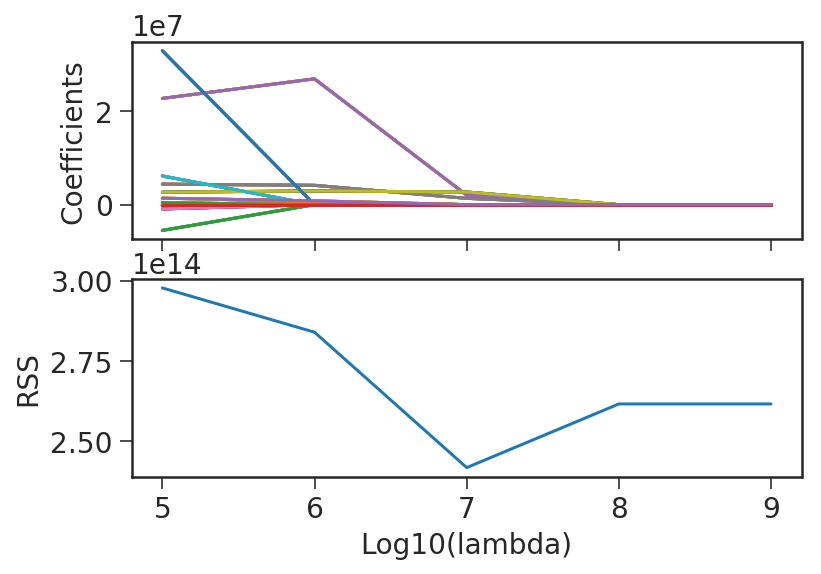

In [462]:
cols = all_features
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
for i in range(mtx.shape[0]):
    ax1.plot(np.log10(lambdas),mtx[cols])
plt.xlabel("Log10(lambda)")
ax1.set_ylabel("Coefficients")
ax2.plot(np.log10(lambdas),CV)
ax2.set_ylabel("RSS")